In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e11/sample_submission.csv")

# EDA

In [3]:
# import important libraries
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

plt.style.use("ggplot")

In [4]:
print("Training Data Shape:",train_data.shape)

train_data.head()

Training Data Shape: (593994, 13)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [5]:
print("Loan paid back percentage")
print("==" * 20 )

train_data['loan_paid_back'].value_counts(normalize=True)

Loan paid back percentage


loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64

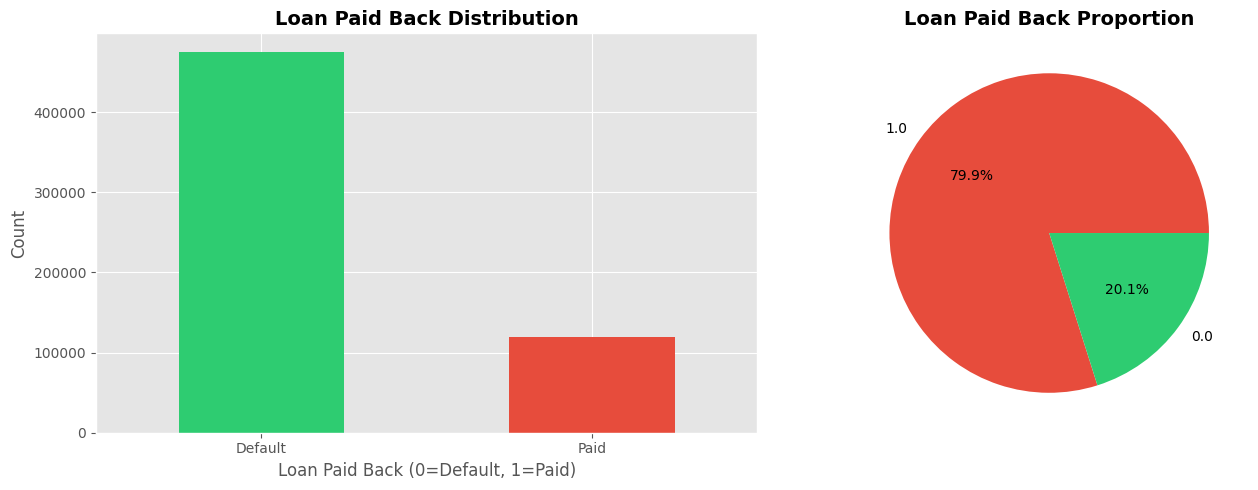

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_data['loan_paid_back'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Loan Paid Back Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Loan Paid Back (0=Default, 1=Paid)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Default', 'Paid'], rotation=0)

train_data['loan_paid_back'].value_counts(normalize=True).plot(kind='pie', ax=axes[1], 
                                                            autopct='%1.1f%%',
                                                            colors=['#e74c3c', '#2ecc71'])
axes[1].set_title('Loan Paid Back Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')
plt.tight_layout()
plt.savefig('01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
train_data.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [9]:
pd.DataFrame(train_data.select_dtypes("O").apply(lambda x:x.unique()))

,0
gender,"[Female, Male, Other]"
marital_status,"[Single, Married, Divorced, Widowed]"
education_level,"[High School, Master's, Bachelor's, PhD, Other]"
employment_status,"[Self-employed, Employed, Unemployed, Retired, Student]"
loan_purpose,"[Other, Debt consolidation, Home, Education, Vacation, Car, Medical, Business]"
grade_subgrade,"[C3, D3, C5, F1, D1, D5, C2, C1, F5, D4, C4, D2, E5, B1, B2, F4, A4, E1, F2, B4, E4, B3, E3, B5, E2, F3, A5, A3, A1, A2]"


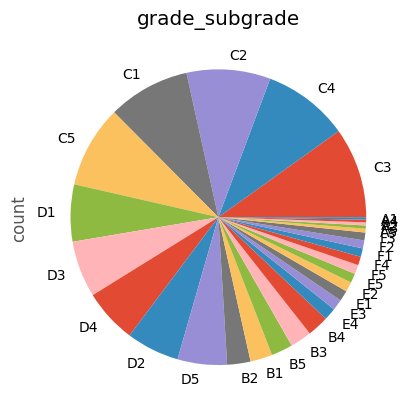

In [10]:
plt.title("grade_subgrade")
train_data.grade_subgrade.value_counts().plot.pie()
plt.show()

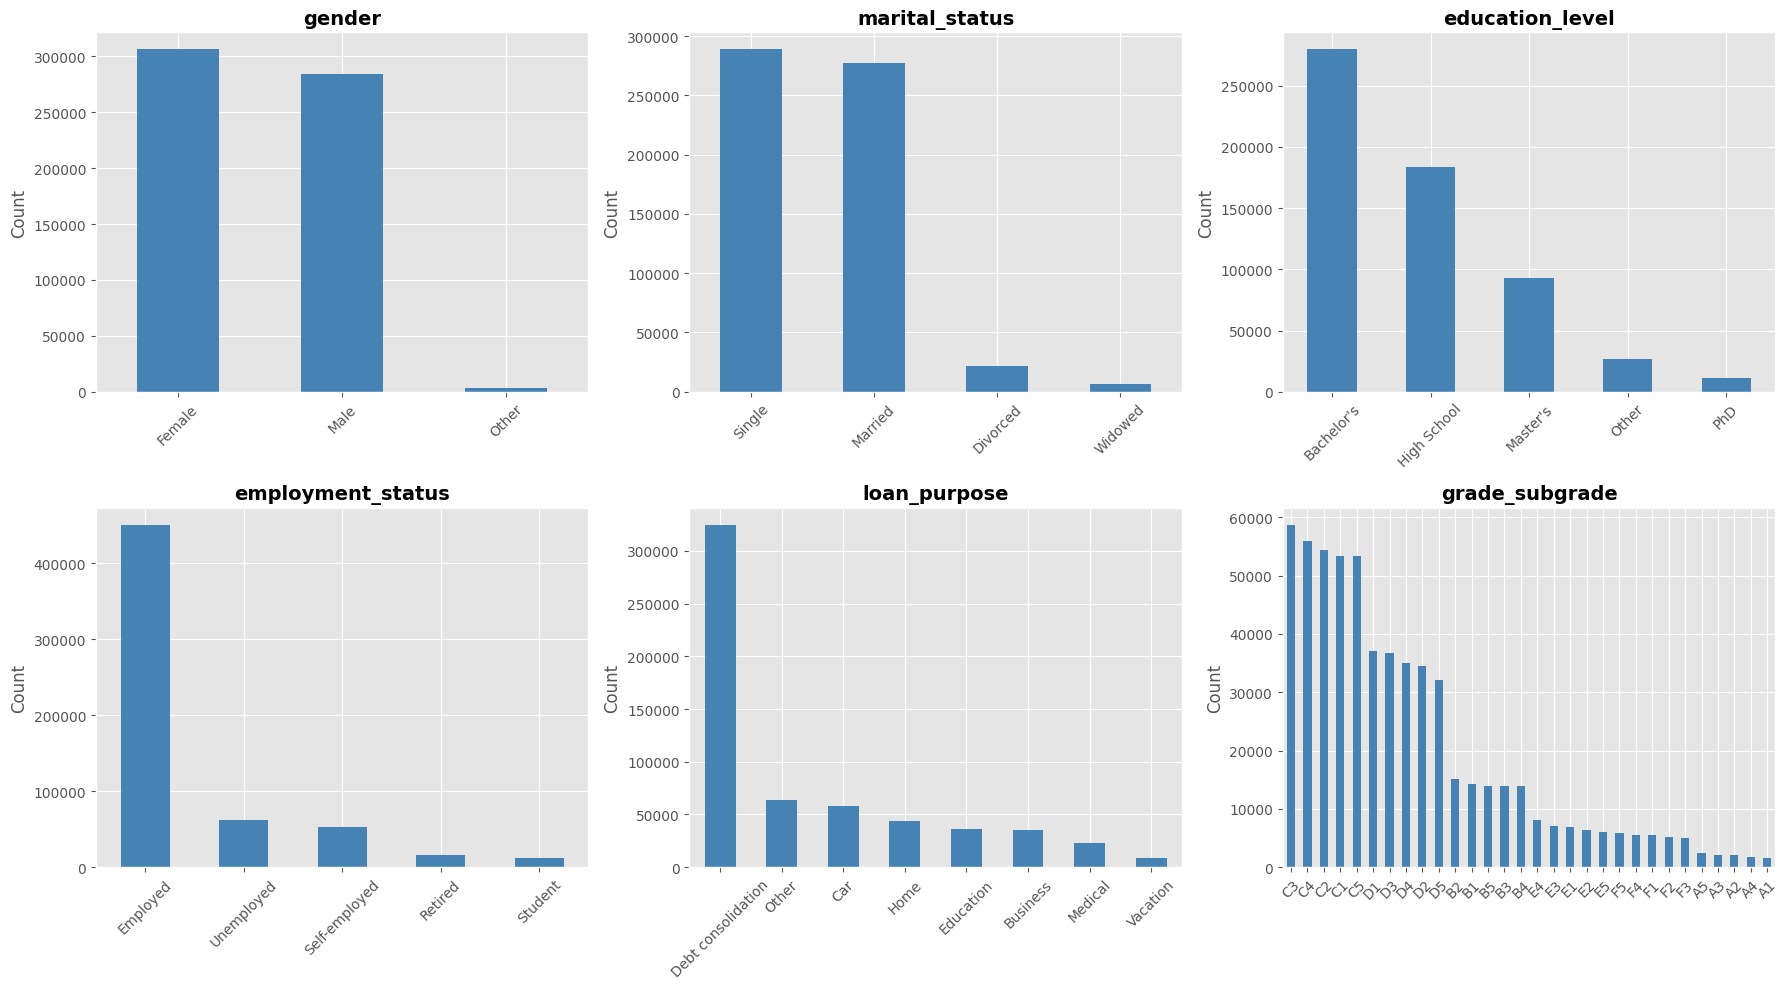

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for col, ax in zip(train_data.select_dtypes("O").columns, axes):
    train_data[col].value_counts().plot.bar(ax=ax, color='steelblue')
    ax.set_title(col, fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Feature Engineering

- gender (3 categories)

> Female, Male, Other
>
> Distribution: Fairly balanced (~51% Female, ~48% Male, ~0.6% Other)



- marital_status (4 categories)

> Single, Married, Divorced, Widowed
>
>  Distribution: Nearly equal Single (~ 49%) and Married (~ 47%)



- education_level (5 categories)

> High School, Bachelor's, Master's, PhD, Other
>
> Order exists: This is ORDINAL data
>
> Distribution: Bachelor's dominates (~47%), then Master's (~31%)



- employment_status (5 categories)

> Employed, Self-employed, Unemployed, Retired, Student
> Distribution: Employed is majority (~76%)



- loan_purpose (8 categories)

> Debt consolidation, Home, Education, Car, Medical, Business, Vacation, Other
> 
> Distribution: Debt consolidation is largest (~55%)



- grade_subgrade (30 categories) ⭐ MOST IMPORTANT

> A1-A5, B1-B5, C1-C5, D1-D5, E1-E5, F1-F5
> 
> This is a loan risk grade - likely highly predictive!
> 
> A = Best credit risk, F = Worst credit risk
> 
> Lower number within grade = better (e.g., A1 > A5)




In [12]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, accuracy_score, f1_score,roc_curve,auc, roc_auc_score
from sklearn.model_selection import train_test_split

In [13]:
# Get all numerical data first

X_train = train_data.drop("id", axis=1).select_dtypes("number").iloc[:,:-1]
y_train = train_data.iloc[:, -1]


In [14]:
def create_features(df, is_train=True):
    """
    Complete feature engineering - returns X_train/X_test ready for modeling
    """
    df = df.copy()
    
    # === NUMERIC FEATURES ===
    
    # Core ratios
    df['loan_to_income_ratio'] = df['loan_amount'] / (df['annual_income'] + 1)
    df['monthly_payment_estimate'] = (df['loan_amount'] * df['interest_rate'] / 100) / 12
    df['payment_to_income_ratio'] = df['monthly_payment_estimate'] / ((df['annual_income'] / 12) + 1)
    df['total_debt_estimate'] = df['annual_income'] * df['debt_to_income_ratio']
    
    # Risk indicators
    df['debt_interest_product'] = df['debt_to_income_ratio'] * df['interest_rate']
    df['high_risk_flag'] = ((df['debt_to_income_ratio'] > 0.4) & (df['interest_rate'] > 15)).astype(int)
    df['credit_quality_score'] = df['credit_score'] / (df['interest_rate'] + 1)
    
    # Log transforms
    df['annual_income_log'] = np.log1p(df['annual_income'])
    df['loan_amount_log'] = np.log1p(df['loan_amount'])
    
    # Polynomial
    df['credit_score_squared'] = df['credit_score'] ** 2
    df['debt_to_income_squared'] = df['debt_to_income_ratio'] ** 2
    
    # Binning
    df['credit_category'] = pd.cut(df['credit_score'], bins=[0, 650, 700, 750, 850], labels=[1, 2, 3, 4]).astype(int)
    df['interest_category'] = pd.cut(df['interest_rate'], bins=[0, 10, 13, 16, 30], labels=[1, 2, 3, 4]).astype(int)
    
    # === CATEGORICAL FEATURES ===
    
    # Education - Ordinal
    education_order = {'Other': 0, 'High School': 1, 'Bachelor\'s': 2, 'Master\'s': 3, 'PhD': 4}
    df['education_ordinal'] = df['education_level'].map(education_order)
    
    # Grade/Subgrade - Ordinal (MOST IMPORTANT!)
    grade_order = {
        'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5,
        'B1':6, 'B2':7, 'B3':8, 'B4':9, 'B5':10,
        'C1':11, 'C2':12, 'C3':13, 'C4':14, 'C5':15,
        'D1':16, 'D2':17, 'D3':18, 'D4':19, 'D5':20,
        'E1':21, 'E2':22, 'E3':23, 'E4':24, 'E5':25,
        'F1':26, 'F2':27, 'F3':28, 'F4':29, 'F5':30
    }
    df['grade_subgrade_ordinal'] = df['grade_subgrade'].map(grade_order)
    
    # Extract grade components
    df['grade_letter'] = df['grade_subgrade'].str[0]
    df['grade_number'] = df['grade_subgrade'].str[1].astype(int)
    grade_letter_order = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6}
    df['grade_letter_ordinal'] = df['grade_letter'].map(grade_letter_order)
    df['high_grade_risk'] = (df['grade_letter_ordinal'] >= 4).astype(int)
    
    # One-hot encoding
    df = pd.get_dummies(df, columns=['gender'], prefix='gender', drop_first=True, dtype=int)
    df = pd.get_dummies(df, columns=['marital_status'], prefix='marital', drop_first=True, dtype=int)
    df = pd.get_dummies(df, columns=['employment_status'], prefix='employment', drop_first=True, dtype=int)
    df = pd.get_dummies(df, columns=['loan_purpose'], prefix='purpose', drop_first=True, dtype=int)
    
    # === INTERACTION FEATURES ===
    df['grade_income_interaction'] = df['grade_subgrade_ordinal'] * df['annual_income_log']
    df['credit_grade_interaction'] = df['credit_score'] * df['grade_letter_ordinal']
    
    # === CLEANUP ===
    drop_cols = ['education_level', 'grade_subgrade', 'grade_letter', 'id']
    
    if is_train and 'loan_paid_back' in df.columns:
        y = df['loan_paid_back']
        drop_cols.append('loan_paid_back')
    else:
        y = None
    
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])
    
    return df, y

X, y = create_features(train_data, is_train=True)
X_test, _ = create_features(test_data, is_train=False)

In [15]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, stratify = y, random_state=7, test_size=0.2)

# Train Machine Learning Models

## Baseline Model (Logistic Regression)

In [16]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train, y_train)

LogisticRegression()

In [17]:
y_validation_pred = baseline_model.predict(X_validation)
f1_score(y_validation, y_validation_pred)

0.8903538573486961

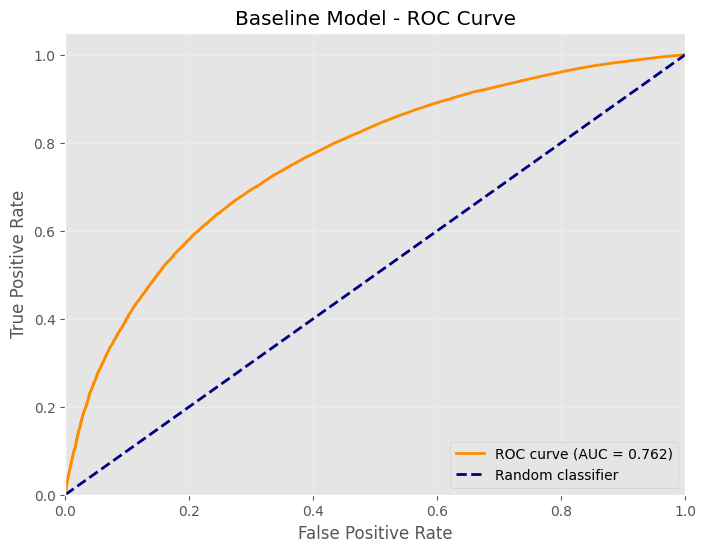

AUC Score: 0.762


In [18]:
y_probs = baseline_model.predict_proba(X_train)

y_validation_probs = baseline_model.predict_proba(X_validation)[:, 1]

fpr, tpr, thresholds = roc_curve(y_validation, y_validation_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline Model - ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.3f}")

In [19]:
test_probs = baseline_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validation, y_validation_probs)
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.3f}")
test_predictions = (test_probs >= optimal_threshold).astype(int)
submission = pd.DataFrame({
    'id': test_data["id"],
    'loan_paid_back': test_predictions
})

Optimal threshold: 0.811


In [20]:
submission.to_csv('submission.csv', index=False)
print(submission['loan_paid_back'].value_counts())

loan_paid_back
1    152039
0    102530
Name: count, dtype: int64


In [21]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import roc_curve, auc, roc_auc_score
# import matplotlib.pyplot as plt

# # Define models to try
# models = {
#     'Random Forest': RandomForestClassifier(n_estimators=100, random_state=7),
#     'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=7),
#     'Decision Tree': DecisionTreeClassifier(random_state=7),
#     'SVM': SVC(probability=True, random_state=7),
#     'KNN': KNeighborsClassifier(n_neighbors=5)
# }

# # Train and evaluate each model
# results = {}
# plt.figure(figsize=(10, 8))

# for name, model in models.items():
#     # Train model
#     model.fit(X_train, y_train)
    
#     # Get predictions
#     y_probs = model.predict_proba(X_validation)[:, 1]
    
#     # Calculate ROC curve
#     fpr, tpr, _ = roc_curve(y_validation, y_probs)
#     roc_auc = auc(fpr, tpr)
    
#     # Store results
#     results[name] = roc_auc
    
#     # Plot
#     plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# # Plot random classifier
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves - Model Comparison')
# plt.legend(loc="lower right")
# plt.grid(alpha=0.3)
# plt.show()

# # Print sorted results
# print("\nModel Performance (sorted by AUC):")
# print("-" * 40)
# for name, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
#     print(f"{name:20s}: {score:.3f}")